In [324]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns
import math

from PIL import Image
import urllib.request

# Load CSV files and plot them

In [325]:
#from google.colab import drive
#drive.mount('/content/drive')

Get files from git hub

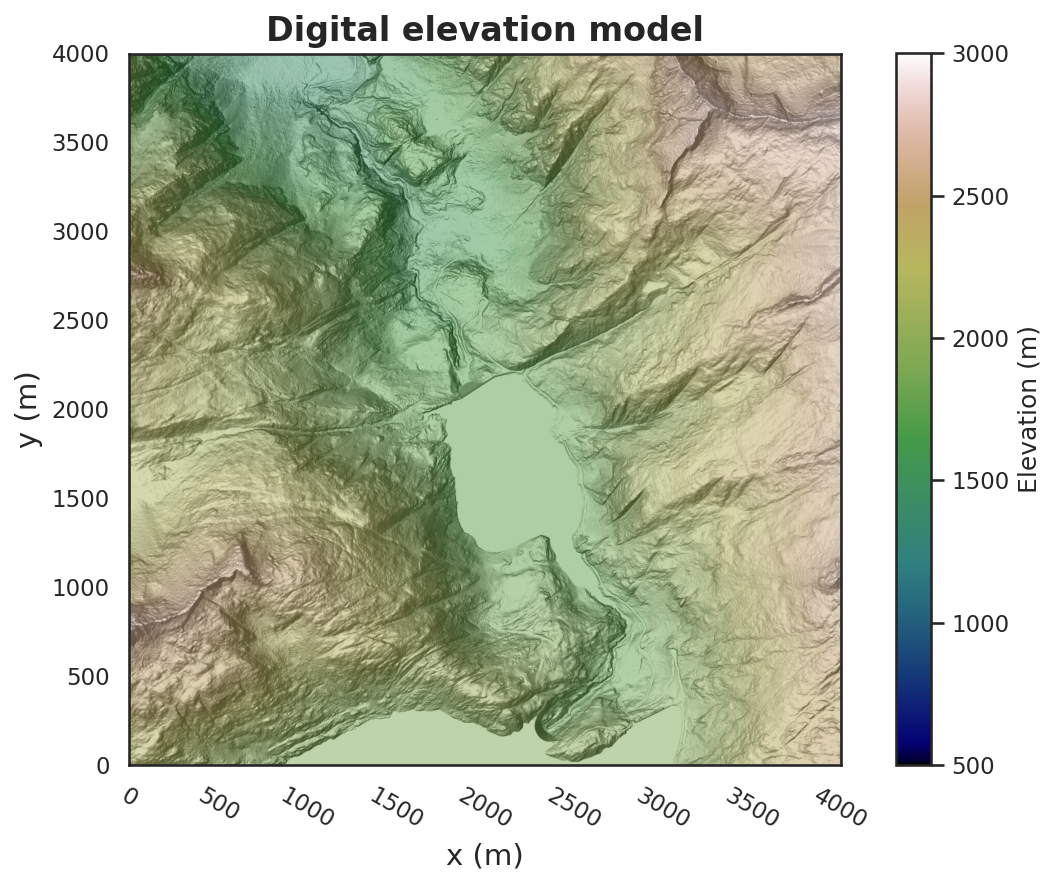

In [326]:
# load all csv tables as individual data frames
# coordinates indicate 2m increments (e.g., 2 = 4m) and refer to the Swiss Coordinate system CH1903+ in the range
# --> the CV titles refer to Original dataset, and the numbers refer to 55, 99, 1515 Kernel for Gaussian Blur filter (see also python script Part 1)

df_list=[]
path = "https://raw.githubusercontent.com/stfabbri/CAS_thesis/main/CSV_data_files/"
#path = "/content/drive/MyDrive/CSV_tables/"
name = "_HoughTest.csv"
index=['Origi','55','99','1515']
for df_ in index:
    df_i = pd.read_csv("{}{}{}".format(path,df_,name),delimiter=';')
    df_list.append(df_i)
    
# Digital elevation model (dem)
url    = 'https://raw.githubusercontent.com/stfabbri/CAS_thesis/main/DEMs%20and%20Hillshades/dem.csv' #read dem
dem    = pd.read_csv(url,header=None)
df_dem = pd.DataFrame(dem)
cmap   = 'gist_earth'

# omnidirectional hillshade
# cmap = sns.color_palette("Spectral_r", as_cmap=True)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')

x, y     =  np.linspace(0,4000,2), np.linspace(0,4000,2)
xv, yv   =  np.meshgrid(x, y)

url_hillshade_omni = 'https://github.com/stfabbri/CAS_thesis/blob/main/DEMs%20and%20Hillshades/HillSha2m_omni.jpg?raw=true'

with urllib.request.urlopen(url_hillshade_omni) as url:
    with open('Hillshade2m_omni.jpg', 'wb') as f:
        f.write(url.read())


Hillsh_image = mpimg.imread('Hillshade2m_omni.jpg')

phys_coords = [0,4000,0,4000]

plt.imshow(Hillsh_image,extent=phys_coords)
plt.imshow(df_dem,alpha=.5,cmap=cmap,extent=phys_coords)
plt.clim(500, 3000)

# colorbar
cbar = plt.colorbar(label='Elevation (m)')
cbar.set_alpha(1)
cbar.draw_all()
# labbels
plt.xlabel('x (m)',size=14)
plt.ylabel('y (m)',size=14)
plt.xticks(np.arange(0, 4000+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 4000+1, step=500),rotation='  0')
plt.title('Digital elevation model',size=16,fontweight="bold")

plt.tight_layout()

#plt.savefig("fig_DEM.png", dpi=300)

In [327]:
# get lengths of individual data frames
length_list=[]
for df in df_list:
    len_i = len(df)
    length_list.append(len_i)

# get positions for splitting 
split_pos   = np.zeros(5)  
split_pos[1::] = np.cumsum(length_list)
split_pos = split_pos.astype(int)
#print('df lengths:',length_list,'df cumsum:',split_pos)

In [328]:
# put all frames together
df_tot = pd.concat(df_list, axis=0)
#print('merged df:',df_tot.shape)

In [329]:
# Calculate 2D properties (pixel domain)
#df_tot= df_tot.rename({'x1': 'x start', 'y1': 'y start', 'x2': 'x end', 'y2': 'y end'}, axis=1, inplace=True)
#df_tot.rename(['x start', 'y start', 'x end', 'y end'], axis=1, inplace=False)

# 2D mid point coordinates
df_tot['x mid'] = (df_tot['x start'] + df_tot['x end'])/2
df_tot['y mid'] = (df_tot['y start'] + df_tot['y end'])/2

# 2D euclidean distance
df_tot['2D segment length'] = round(np.sqrt((df_tot['x end']-df_tot['x start'])**2 +
                                            (df_tot['y end']-df_tot['y start'])**2),2)

# scale 2D properties to physical dimensions (i.e. in m) for length calculations

# cell size [m]
scale_fac = 2

df_tot['x start phys'] = scale_fac*df_tot['x start']
df_tot['y start phys'] = np.absolute(scale_fac*df_tot['y start'] -4000)
df_tot['x end phys']   = scale_fac*df_tot['x end']
df_tot['y end phys']   = np.absolute(scale_fac*df_tot['y end'] -4000)

# 2D mid point coordinates
df_tot['x mid phys'] = (df_tot['x start phys'] + df_tot['x end phys'])/2
df_tot['y mid phys'] = (df_tot['y start phys'] + df_tot['y end phys'])/2

# 2D euclidean distance
df_tot['2D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2),2)

# Fault strike orientation
df_tot['fault strike']   = abs(round(np.rad2deg(np.arctan((df_tot['y end']-df_tot['y start'])/
                                                      (df_tot['x end']-df_tot['x start'])))+90,2)-180)

df_tot.head(10)

x start  y start  x end  ...  y mid phys  2D segment length phys  fault strike
0      499      817    524  ...      2380.0                   57.31        119.25
1      969     1714    983  ...       539.0                   71.69         22.99
2     1480      520   1504  ...      2949.0                   52.80         65.38
3      431      984    463  ...      2035.0                   64.28         95.36
4        7     1605     36  ...       802.0                   62.77        112.48
5      933      781    957  ...      2445.0                   50.00        106.26
6      717      696    762  ...      2572.0                  115.26         51.34
7     1565     1812   1593  ...       348.0                   79.20         45.00
8     1805     1867   1812  ...       244.0                   46.17         17.65
9      565     1356    589  ...      1315.0                   72.25        138.37

[10 rows x 15 columns]

In [330]:
# Calculate 3D properties

# x and y needed switching for the lookup, due to the difference in geograph. and math. coordinates?
df_tot['z start phys'] = df_dem.lookup(df_tot['y start'].astype('int'),df_tot['x start'].astype('int'))
df_tot['z end phys']   = df_dem.lookup(df_tot['y end'].astype('int'),df_tot['x end'].astype('int'))
df_tot['z mid phys']   = df_dem.lookup(round(df_tot['y mid'].astype('int')-.5,0),round(df_tot['x mid'].astype('int')-.5,0))

# 3D euclidean distance
df_tot['3D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2 +
                                            (df_tot['z end phys']-df_tot['z start phys'])**2),2)

# Get max and min values
column = df_tot["z mid phys"]
max_z  = 100*math.ceil(column.max()/100)
min_z  = 100*math.floor(column.min()/100)

df_tot.head(10)

x start  y start  x end  ...  z end phys  z mid phys  3D segment length phys
0      499      817    524  ...        1939        1943                   58.01
1      969     1714    983  ...        2060        2046                   82.10
2     1480      520   1504  ...        2312        2326                   59.30
3      431      984    463  ...        2009        2022                   68.97
4        7     1605     36  ...        2655        2680                   71.87
5      933      781    957  ...        1719        1717                   55.04
6      717      696    762  ...        1655        1674                  122.00
7     1565     1812   1593  ...        1951        1937                   85.42
8     1805     1867   1812  ...        2335        2330                   46.70
9      565     1356    589  ...        2275        2288                   81.63

[10 rows x 19 columns]

In [331]:
#slice merged df_tot and store in df list 
#savind df to extended DB  

df_index=['Origi','55','99','1515']
df_list2=[]
len_list=[]
for i in range(0,len(df_index),1):
        df_i= df_tot.iloc[split_pos[i]:split_pos[(i+1)],:]
        df_list2.append(df_i)
        df_i.to_csv(df_index[i],index=False)
              
for i in range(0,len(df_index),1):
        len_i = len(df_list2[i])
        len_list.append(len_i)

Check number of entries (Lineaments) per dataset

In [332]:
for i in range(0,len(df_index),1):
    print(len_list[i],'entries for',df_index[i])

3615 entries for Origi
178 entries for 55
329 entries for 99
148 entries for 1515


In [333]:
#df_list2[0]

Plot fault strike vs segment length

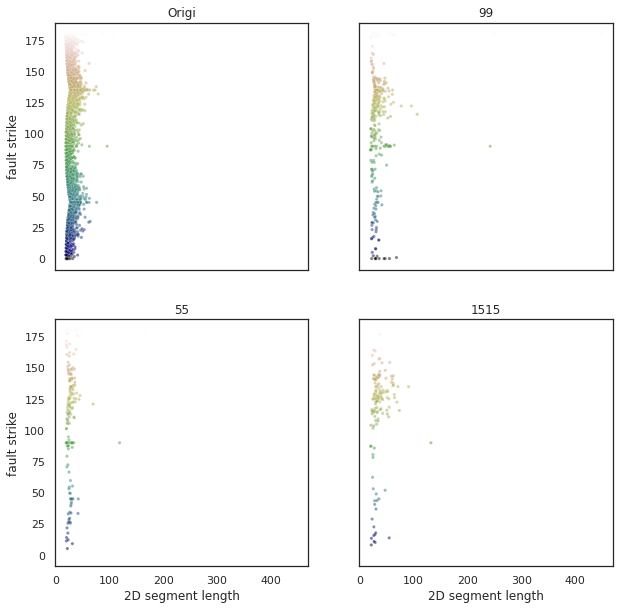

In [334]:
#fig, ax = plt.subplots(2,2,figsize=(15, 20))
f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = '2D segment length',y = 'fault strike',s=1)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = '2D segment length', y= 'fault strike', hue = 'fault strike',
                            legend=False, palette=cmap, ax=axes[k,j], size=1,
                            sizes=(10,500), alpha=0.5)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,250)
            
            
        i=i+1
#df_tot['2D segment length']


In [335]:
#degree = '$^{\circ}$'
#print(degree)

Text(0.05, 0.5, 'Y (m)')

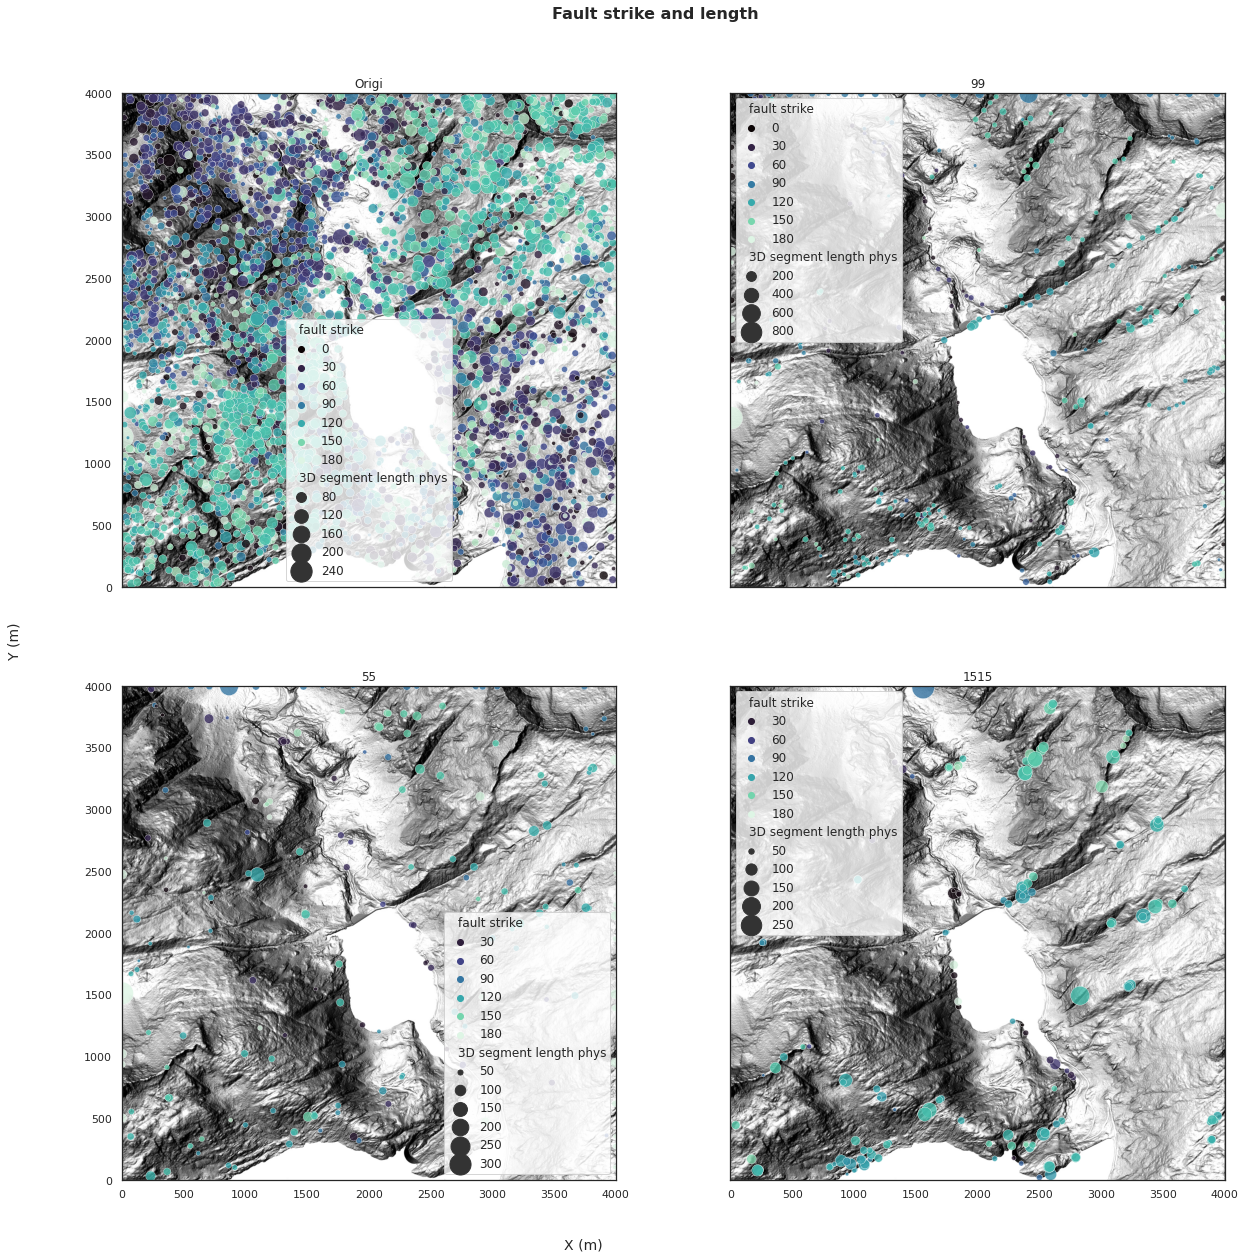

In [336]:
# Orientation & Lengths
# Attribute comparison - as mid points
sns.set(style="white", palette="muted", color_codes=True)
cmap ="mako"
mkrsize = 5
alpha_val = 0.8
f_vis1, axes = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True, facecolor='w', edgecolor='k')

# plot mid points
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 5:
            sns.scatterplot(data = df_list2[i], x = 'x mid phys', y= 'y mid phys', hue = 'fault strike', 
                            legend="brief", palette=cmap, ax=axes[k,j], size='3D segment length phys',
                            sizes=(10,500), alpha=alpha_val)
            axes[k,j].set_title(index[i])
            axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            axes[k,j].imshow(image,extent=phys_coords) 
        else:
            sns.scatterplot(data = df_list2[i], x = 'x mid phys', y= 'y mid phys', hue = 'fault strike',
                            legend="brief", palette=cmap, ax=axes[k,j], size='3D segment length phys',
                            sizes=(10,500), alpha=alpha_val)
            axes[k,j].set_title(index[i])
            axes[k,j].imshow(Hillsh_image,extent=phys_coords)
        i=i+1
        
# make title and subtitles
f_vis1.suptitle('Fault strike and length', y=0.94, fontsize=16, fontweight='bold')  
plt.setp(axes, xlabel='', ylabel='')
f_vis1.text(0.45, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
f_vis1.text(0.05, 0.5 , 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')
#plt.savefig("fig_fault_strike_and_length.png", dpi=300)

Text(0.05, 0.5, 'Y (m)')

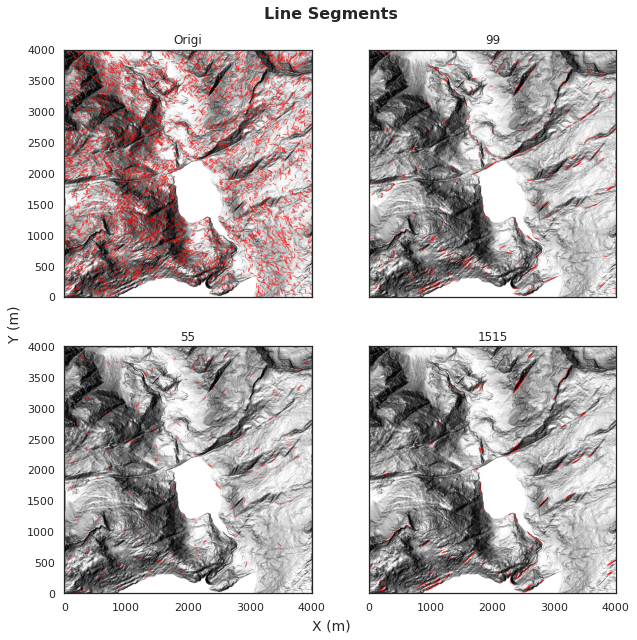

In [337]:
# line check - slow due number of lines

f_lines, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
segm_width = 1
alpha_val  = .5
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        axes[k,j].plot((df_list2[i]['x start phys'],df_list2[i]['x end phys']),
                       (df_list2[i]['y start phys'],df_list2[i]['y end phys']),
                        color='red',alpha=alpha_val,linewidth=segm_width)
        axes[k,j].set_title("{}{}".format(index[i],degree))
        axes[k,j].imshow(Hillsh_image,extent=phys_coords)
        i=i+1
        
# make title and subtitles
f_lines.suptitle('Line Segments', y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='', ylabel='')
f_lines.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
f_lines.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

#plt.savefig("fig_Calculated_line_segments.png", dpi=300)

In [338]:
# Attribute comparision - in data dimensions
# absolute key values for orientation
r_index=['mean_or','med_or','std_or','mean_2D_length','med_2D_length','std_2D_length','mean_3D_length','med_3D_length','std_3D_length']
Res_stat=np.zeros((len(r_index),len(index)))
k=0                                                            
for df in df_list2:                                                 
    Res_stat[0,k]=round(df['fault strike'].mean(),1)
    Res_stat[1,k]=round(df['fault strike'].median(),1)
    Res_stat[2,k]=round(df['fault strike'].std(),1)
    Res_stat[3,k]=round(df['2D segment length phys'].mean(),1)
    Res_stat[4,k]=round(df['2D segment length phys'].median(),1)
    Res_stat[5,k]=round(df['2D segment length phys'].std(),1)
    Res_stat[6,k]=round(df['3D segment length phys'].mean(),1)
    Res_stat[7,k]=round(df['3D segment length phys'].median(),1)
    Res_stat[8,k]=round(df['3D segment length phys'].std(),1)
    k=k+1
#print(Res_stat)
df_stats = pd.DataFrame(Res_stat, columns=index, index=r_index)
df_stats

Origi     55     99   1515
mean_or         100.5  113.0  107.5  115.9
med_or          108.9  121.0  118.4  125.9
std_or           49.9   46.4   43.8   37.0
mean_2D_length   57.4   58.6   71.2   73.0
med_2D_length    54.6   53.1   58.8   64.3
std_2D_length    14.6   27.9   60.9   29.6
mean_3D_length   63.9   63.1   77.0   77.3
med_3D_length    60.0   58.2   62.8   68.1
std_3D_length    17.5   28.5   67.8   34.2

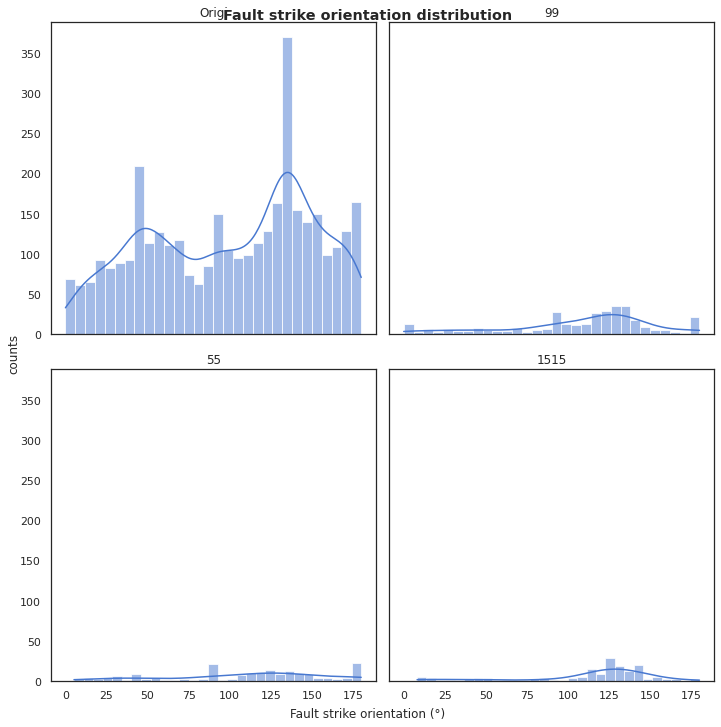

In [339]:
#orientation histograms

x = np.linspace(0,180,180)
f_his1, axes = plt.subplots(2, 2, figsize=(10, 10),sharex=True, sharey=True)
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
    #axes[k,j].plot(x, norm.pdf(x,df_stats.iloc[0,l],df_stats.iloc[2,l]),'b-', lw=2,)   #simple unimodal norm. pdf fit
        sns.histplot(df_list2[i]['fault strike'], kde=True,ax=axes[k,j],bins=30)
        axes[k,j].set_title("{}{}".format(index[i],degree))
        i=i+1
    
# make title and subtitles
f_his1.suptitle('Fault strike orientation distribution',fontsize='large',ha='center',fontweight='bold')
plt.setp(axes, xlabel='', ylabel='')
f_his1.text(0.5, 0.0, 'Fault strike orientation (°)', ha='center', va='center', fontsize=12)
f_his1.text(0.0, 0.5, 'counts', ha='left', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig("fig_fault_strike_histograms.png", dpi=300)

Some statistics on Circular Data

In [340]:
import cmath
import numpy as np
import scipy.stats as stats

# Circular mean of angle data(default to degree)
a = np.deg2rad(df_tot['fault strike'])
angles_complex = np.frompyfunc(cmath.exp, 1, 1)(a * 1j)
mean = cmath.phase(angles_complex.sum()) % (2 * np.pi)
print("Circular mean")
print(np.rad2deg(mean))

Circular mean
104.52927874564932


In [341]:
# Circular variance of angle data(default to degree)
r =abs(angles_complex.sum()) / len(df_tot['fault strike'])
print("Circular Variance:")
print("1 - R=",1-r)
print("R=",r)

Circular Variance:
1 - R= 0.32461016230187945
R= 0.6753898376981206


In [342]:
df_list2[0]

x start  y start  x end  ...  z end phys  z mid phys  3D segment length phys
0         499      817    524  ...        1939        1943                   58.01
1         969     1714    983  ...        2060        2046                   82.10
2        1480      520   1504  ...        2312        2326                   59.30
3         431      984    463  ...        2009        2022                   68.97
4           7     1605     36  ...        2655        2680                   71.87
...       ...      ...    ...  ...         ...         ...                     ...
3610        2     1528      2  ...        2457        2467                   49.40
3611     1526     1336   1547  ...        2078        2082                   56.04
3612      358     1008    378  ...        2120        2129                   48.17
3613      751       97    767  ...        1608        1600                   60.43
3614      913      751    933  ...        1689        1684                   63.12

[3615 rows x 19 columns]

In [343]:
#max(df_list2[0]['2D segment length'])

In [344]:
#dir(df_list2[0]['2D segment length'])

In [345]:
#type(df_tot['fault strike'])

In [346]:
#df_list2[]['x start phys']

# K Means CLustering

In [347]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer
import os
import tarfile

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import entropy

# Check for various correlations and clusterings

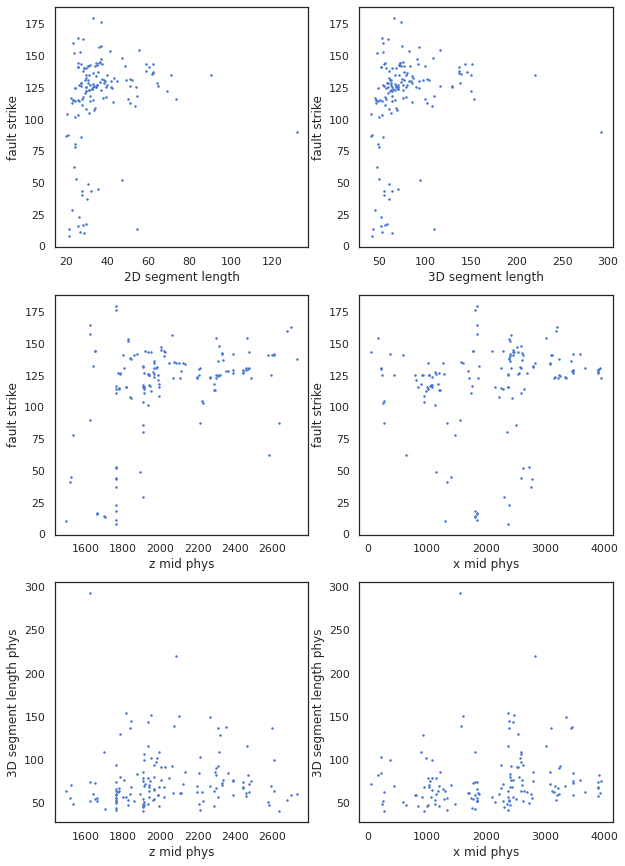

In [348]:
# List 3 = Gaussian Blur 1515
m=3
#m=2    # List 2 = Gaussian Blur 99
#m=1    # List 1 = Gaussian Blur 55
#m=0    # List 0 = Original, unblurred

figure(figsize=(10,15))
plt.subplot(321)
plt.plot(df_list2[m]['2D segment length'],df_list2[m]['fault strike'],'o', color='b', markersize=1.5)
plt.xlabel('2D segment length')
plt.ylabel('fault strike')
plt.subplot(322)
plt.plot(df_list2[m]['3D segment length phys'],df_list2[m]['fault strike'],'o', color='b', markersize=1.5)
plt.xlabel('3D segment length')
plt.ylabel('fault strike')
plt.subplot(323)
plt.plot(df_list2[m]['z mid phys'],df_list2[m]['fault strike'],'o', color='b', markersize=1.5)
plt.xlabel('z mid phys')
plt.ylabel('fault strike')
plt.subplot(324)
plt.plot(df_list2[m]['x mid phys'],df_list2[m]['fault strike'],'o', color='b', markersize=1.5)
plt.xlabel('x mid phys')
plt.ylabel('fault strike')
plt.subplot(325)
plt.plot(df_list2[m]['z mid phys'],df_list2[m]['3D segment length phys'],'o', color='b', markersize=1.5)
plt.xlabel('z mid phys')
plt.ylabel('3D segment length phys')
plt.subplot(326)
plt.plot(df_list2[m]['x mid phys'],df_list2[m]['3D segment length phys'],'o',color='b', markersize=1.5)
#plt.plot(df_list2[n]['x mid phys'],df_list2[n]['3D segment length phys'],'o',color='b', markersize=1.5)
#plt.plot(df_list2[k]['x mid phys'],df_list2[k]['3D segment length phys'],'o',color='r', markersize=1.5)
plt.xlabel('x mid phys')
plt.ylabel('3D segment length phys')

plt.show()

# Clustering Fault strike vs z mid phys

In [349]:
my_array_zmp =np.array(df_list2[m]['z mid phys'])
#t_my_array1 =np.transpose(my_array1)
my_array_fs =np.array(df_list2[m]['fault strike'])
#t_my_array2 =np.transpose(my_array2)
my_array_zmp_fs = np.asarray([my_array_zmp, my_array_fs])
print(my_array_zmp_fs.shape)

(2, 148)


In [350]:
t_my_array_zmp_fs = np.transpose(my_array_zmp_fs)
print(t_my_array_zmp_fs.shape)

(148, 2)


# Clustering fault strike vs 3D segment length

In [351]:
my_array_3Dsl =np.array(df_list2[m]['3D segment length phys'])
#t_my_array1 =np.transpose(my_array1)
my_array_fs =np.array(df_list2[m]['fault strike'])
#t_my_array2 =np.transpose(my_array2)
my_array_3Dsl_fs = np.asarray([my_array_3Dsl, my_array_fs])
print(my_array_3Dsl_fs.shape)
t_my_array_3Dsl_fs = np.transpose(my_array_3Dsl_fs)
print(t_my_array_3Dsl_fs.shape)

(2, 148)
(148, 2)


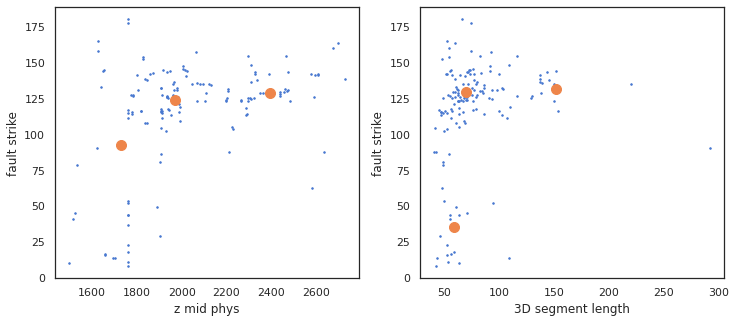

In [352]:
figure(figsize=(12,5))
plt.subplot(121)
clusterer1 = KMeans(n_clusters=3, random_state=10)
clusterer1.fit(t_my_array_zmp_fs)
plt.plot(df_list2[m]['z mid phys'],df_list2[m]['fault strike'],'o', markersize=1.5)
plt.plot(clusterer1.cluster_centers_[:,0],clusterer1.cluster_centers_[:,1],'o',markersize=10)
plt.xlabel('z mid phys')
plt.ylabel('fault strike')


plt.subplot(122)
clusterer2 = KMeans(n_clusters=3, random_state=10)
clusterer2.fit(t_my_array_3Dsl_fs)
plt.plot(df_list2[m]['3D segment length phys'],df_list2[m]['fault strike'],'o', markersize=1.5)
plt.plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
plt.xlabel('3D segment length')
plt.ylabel('fault strike')
plt.show()

In [353]:
#clusterer.cluster_centers_[:,:]

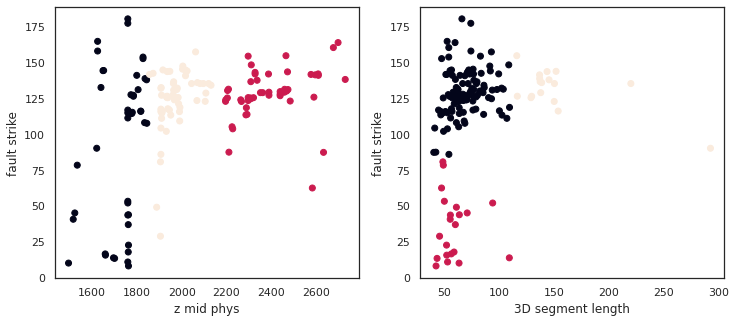

In [354]:
figure(figsize=(12,5))
plt.subplot(121)
cluster_labels=clusterer1.predict(t_my_array_zmp_fs)
plt.scatter(t_my_array_zmp_fs[:,0],t_my_array_zmp_fs[:,1],c=cluster_labels)
plt.xlabel('z mid phys')
plt.ylabel('fault strike')

plt.subplot(122)
cluster_labels=clusterer2.predict(t_my_array_3Dsl_fs)
plt.scatter(t_my_array_3Dsl_fs[:,0],t_my_array_3Dsl_fs[:,1],c=cluster_labels)
plt.xlabel('3D segment length')
plt.ylabel('fault strike')
plt.show()

# Silhoutte for clusterer 1: z mid phys vs fault strike

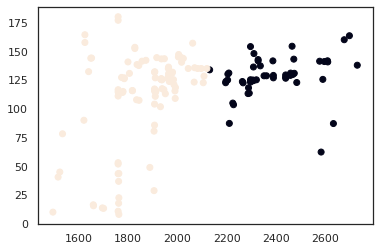

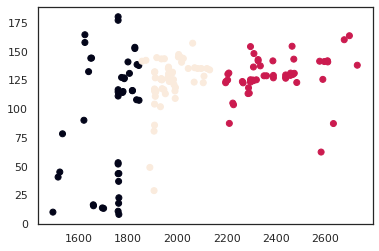

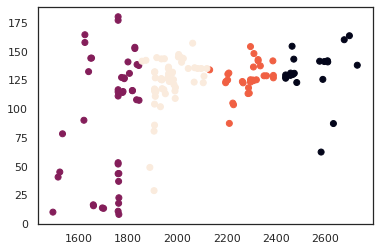

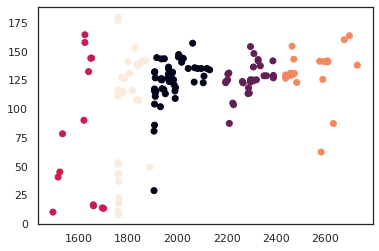

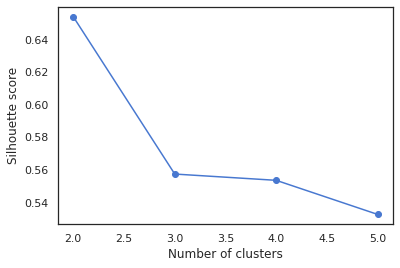

In [355]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10)
    cluster_labels = clusterer.fit_predict(t_my_array_zmp_fs)
    score=silhouette_score(t_my_array_zmp_fs,cluster_labels)
    sil.append(score)
    plt.scatter(t_my_array_zmp_fs[:,0],t_my_array_zmp_fs[:,1],c=cluster_labels)
    plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()

# #Silhoutte for clusterer 1: 3D length phys vs fault strike

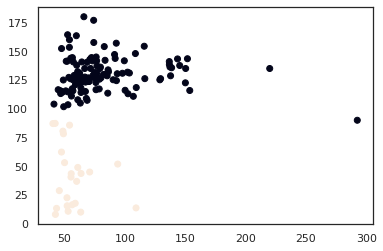

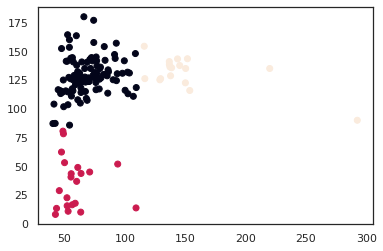

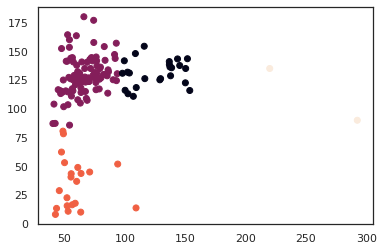

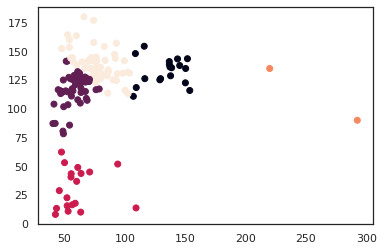

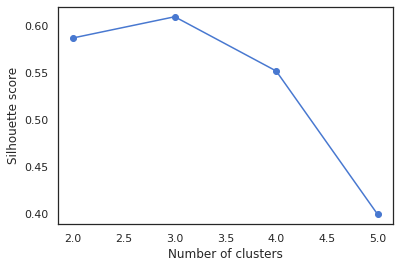

In [356]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10)
    cluster_labels = clusterer.fit_predict(t_my_array_3Dsl_fs)
    score=silhouette_score(t_my_array_3Dsl_fs,cluster_labels)
    sil.append(score)
    plt.scatter(t_my_array_3Dsl_fs[:,0],t_my_array_3Dsl_fs[:,1],c=cluster_labels)
    plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()

# Dedrogram for z mid phys vs fault strike

In [357]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy
from ipywidgets import interact
from scipy.cluster.hierarchy import fcluster

#points=km_load_th1()
Z = hierarchy.linkage(t_my_array_zmp_fs, 'single')
n_clusters=int(np.max(Z[:,[0,1]].flatten()))
print(n_clusters)

@interact
def plot(t=(0,55,1)):  
    fig, axes=plt.subplots(1,2,figsize=(15,10), gridspec_kw={'width_ratios': [1, 2]})
    fl = fcluster(Z,t=t,criterion='distance')
    maps={}
    for clust in range(n_clusters):
        maps[clust]=(fl==clust)
    c=0
    for clust in range(n_clusters):
        if np.sum(maps[clust])>0:
            c+=1
    plt.figure(figsize=(19,5))
    d = hierarchy.dendrogram(Z,ax=axes[1], color_threshold=t)
    axes[1].axhline(t,linestyle='--',color='red')
    axes[1].set_ylabel('Cluster distance')
    axes[1].axes.get_xaxis().set_visible(False)
    axes[1].set_xlabel('Points')
    axes[1].set_title(f'Number clusters: {c}')
    axes[0].scatter(t_my_array3[d['leaves'],0],t_my_array3[d['leaves'],1])

293


interactive(children=(IntSlider(value=27, description='t', max=55), Output()), _dom_classes=('widget-interact'…

# Covariance

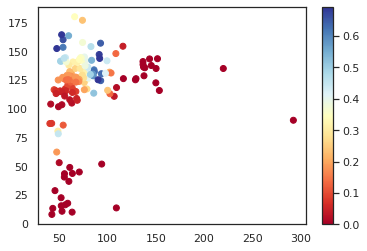

In [358]:
#Applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, 
#but also a probability distribution over the clusters. 

#From this probability distribution, you can compute for each point the entropy of the corresponging 
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. 
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

# In detail you shoud:
# 1. Instantiate a GaussianMixture object with the number of clusters that you expect
# 2. fit the object on the dataset with the fit method 

from scipy.stats import entropy
points=t_my_array_3Dsl_fs

plt.figure()
clf = GaussianMixture(n_components=3, covariance_type='full')

clf.fit(points)

# 3. compute the cluster probabilities using the method predict_proba. This will return a matrix of 
# dimension npoints x nclusters
# 4. use the entropy function ( from scipy.stats import entropy ) to evaluate for each point the uncertainty of the 
#prediction

cluster_labels_prob=clf.predict_proba(points)

entropies=[]
for point in range(len(cluster_labels_prob)):
    entropies.append(entropy(cluster_labels_prob[point]))

# 5. Plot the points colored accordingly to their uncertanty. 

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)
    